# Change points detection algorithm
- From keypoint MoSeq
- Basseville, M., and Nikiforov, I.V. (1993). Detection of abrupt changes (Prentice-Hall Publishing).

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# --Machine learning and statistics
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema
from scipy.stats import zscore
from scipy.stats import ttest_1samp

from one.api import ONE
one = ONE()


Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/tmpfbul0_za/cache.zip Bytes: 114884365


100%|██████████| 109.56226825714111/109.56226825714111 [00:47<00:00,  2.33it/s]


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Preprocess list of design matrices

In [3]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:1]):
    
    # Trials data
    session = design_matrices[m][14:-4]
    
    #session = '2e6e179c-fccc-4e8f-9448-ce5b6858a183'
    #mat = 'design_matrix_2e6e179c-fccc-4e8f-9448-ce5b6858a183_0.1new_version'
    
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # # Normalize between 0 and 1
      normalizer = Normalizer()  # norm='max'
      normalized = normalizer.fit_transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    # matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

In [4]:
use_data = design_matrix[var_names].copy()  # To keep the column names
use_data[var_names] = matrix_all[mat][0]

use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])

### Parameters
Need to do grid-search on this

In [5]:
k = 4  # bin lag for derivative calculation
h = 01.5  # thresold??
sigma = 0.43  # for Gaussian filter

k = 2
h = 0.5
sigma = 0.7

shuffle_iters = 1000

### Derivative

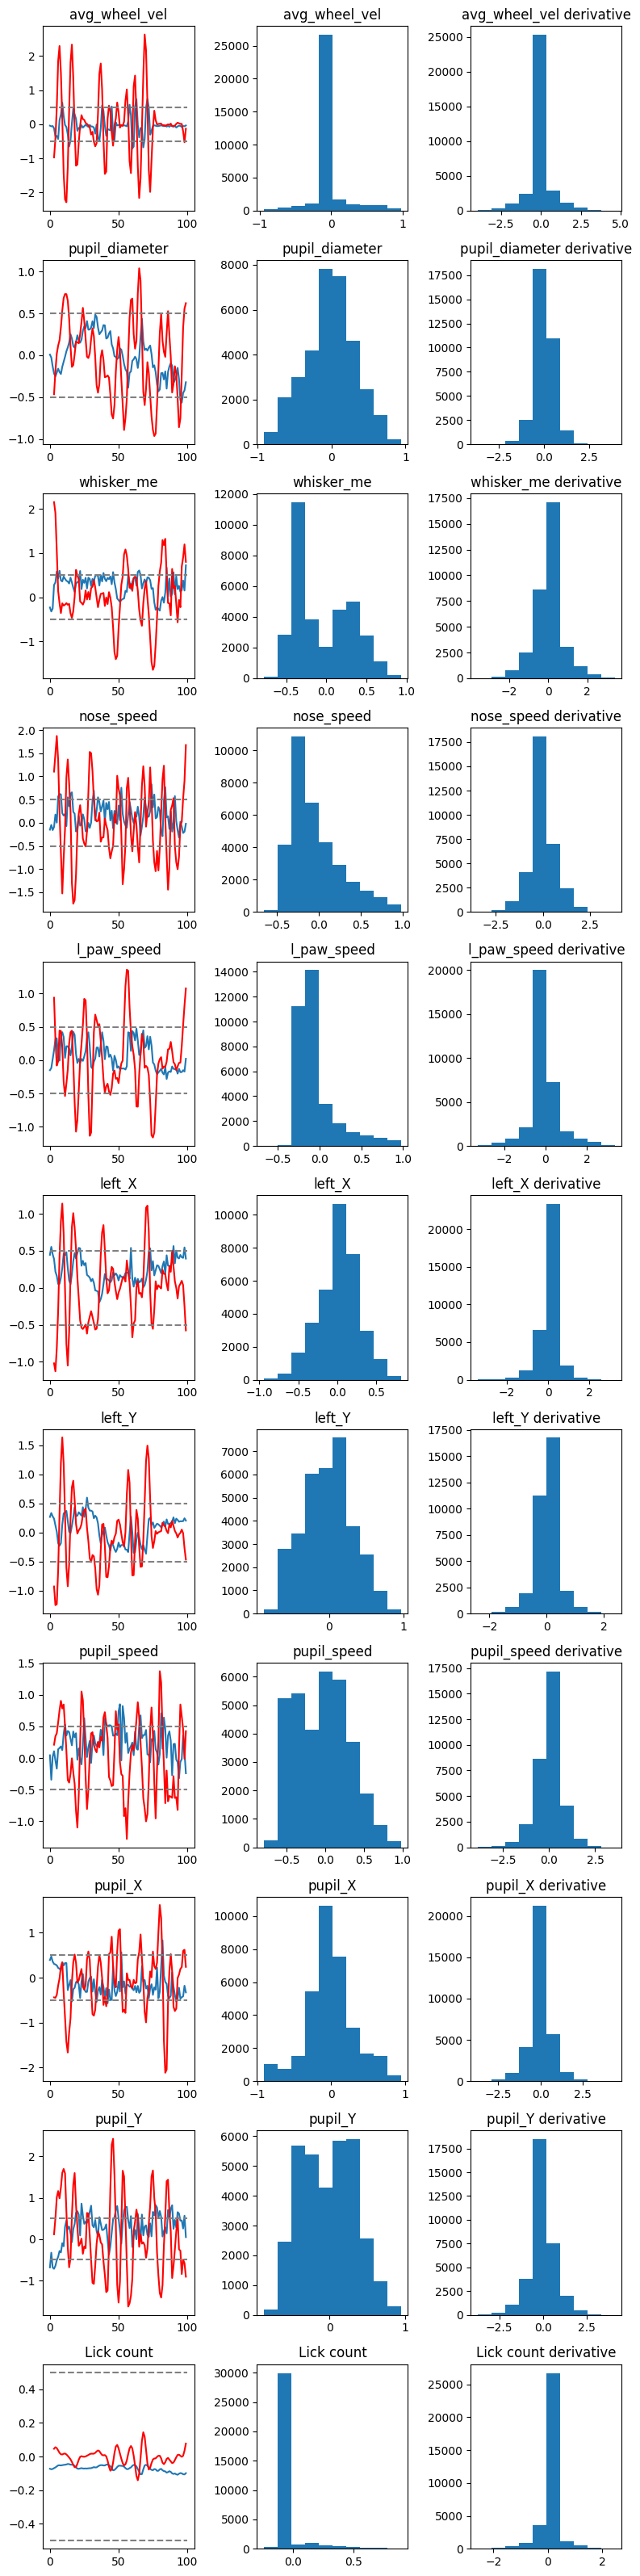

In [6]:
derivative = use_data.copy()
features = use_data.keys()

min = 0
max = 100

fig, ax = plt.subplots(nrows=len(features) , ncols=3, sharex=False, sharey=False, figsize=[8, 32])

for i, feat in enumerate(features):
    derivative[feat] = derivative[feat].shift(-3) + derivative[feat].shift(-2) + derivative[feat].shift(-1) - derivative[feat].shift(1) - derivative[feat].shift(2) - derivative[feat].shift(3) 
    
    ax[i, 0].plot(use_data[feat][min:max])
    ax[i, 0].plot(derivative[feat][min:max], color='red')
    ax[i, 0].hlines(h, min, max, linestyles='--', color='Gray')
    ax[i, 0].hlines(-h, min, max, linestyles='--', color='Gray')
    ax[i, 2].hist(derivative[feat])
    ax[i, 1].hist(use_data[feat])
    ax[i, 0].set_title(feat)
    ax[i, 2].set_title(str(feat + ' derivative'))
    ax[i, 1].set_title(feat)

plt.tight_layout()


### Thresholding

In [7]:
df_zscore = derivative[np.array(features)]
thresholded = df_zscore.apply(zscore, nan_policy='omit')

for i, feat in enumerate(features):
    thresholded.loc[(thresholded[feat] >= -h) & (thresholded[feat] <= h), feat] = 0
    thresholded.loc[thresholded[feat] > h, feat] = 1
    thresholded.loc[thresholded[feat] < -h, feat] = 1

summed_threshold = np.sum(thresholded, axis=1)


### Gaussian filter

In [9]:
# Apply Gaussian filter
smoothed_signal = gaussian_filter1d(summed_threshold, sigma=sigma)

(0.0, 100.0)

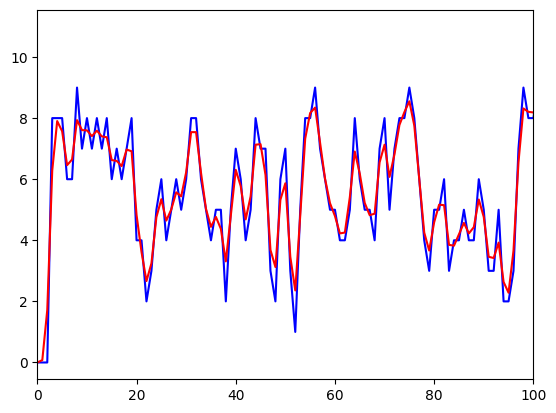

In [10]:
plt.plot(summed_threshold, color='blue')
plt.plot(smoothed_signal, color='red')
plt.xlim([0, 100])

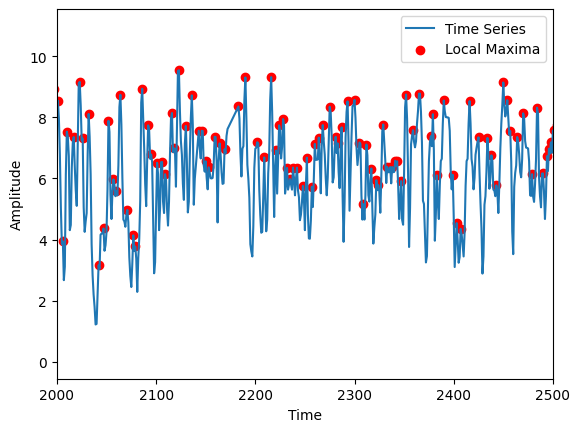

In [11]:
local_maxima = argrelextrema(smoothed_signal, np.greater)

time = design_matrix['Bin']
# Plot the time series and local maxima
plt.plot(time, smoothed_signal, label='Time Series')
plt.scatter(time[local_maxima[0]], smoothed_signal[local_maxima[0]], color='red', label='Local Maxima')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim([2000, 2500])
plt.show()

## Functions

In [38]:
def changepoints(use_data, h, sigma):
        
    features = use_data.keys()

    # Derivative
    derivative = use_data.copy()
    for i, feat in enumerate(features):
        derivative[feat] = derivative[feat].shift(-3) + derivative[feat].shift(-2) + derivative[feat].shift(-1) - derivative[feat].shift(1) - derivative[feat].shift(2) - derivative[feat].shift(3) 

    # z-score
    df_zscore = derivative[np.array(features)]
    thresholded = df_zscore.apply(zscore, nan_policy='omit')

    # Threshold
    for i, feat in enumerate(features):
        # thresholded[pc] = thresholded[pc] * np.nan
        thresholded.loc[(thresholded[feat] >= -h) & (thresholded[feat] <= h), feat] = 0
        thresholded.loc[thresholded[feat] > h, feat] = 1
        thresholded.loc[thresholded[feat] < -h, feat] = 1

    # Sum
    summed_threshold = np.sum(thresholded, axis=1)

    # Smooth
    smoothed_signal = gaussian_filter1d(summed_threshold, sigma=sigma)
        
    return smoothed_signal


def cyclic_permutation(use_data):
    
    permuted_data = use_data.copy()
    
    features = use_data.keys()
    for f, feat in enumerate(features):
        # Generate a random interval for cyclic permutation
        random_interval = np.random.randint(1, np.shape(use_data)[0])

        # Cyclically permute the time series
        permuted_data[feat] = np.roll(use_data[feat], random_interval)

    return permuted_data


def shuffled(use_data, shuffle_iters, h, sigma):
    
    changepoints_shuffled = np.zeros((shuffle_iters, np.shape(use_data)[0]))
    
    features = use_data.keys()

    for s in range(shuffle_iters):
        
        # Randomly permute each keypoint timeseries
        permuted_data = cyclic_permutation(use_data)

        # Derivative
        derivative = permuted_data.copy()
        for i, feat in enumerate(features):
            derivative[feat] = derivative[feat].shift(-3) + derivative[feat].shift(-2) + derivative[feat].shift(-1) - derivative[feat].shift(1) - derivative[feat].shift(2) - derivative[feat].shift(3) 

        # z-score 
        df_zscore = derivative[np.array(features)]
        thresholded = df_zscore.apply(zscore, nan_policy='omit')

        # Threshold
        for i, feat in enumerate(features):
            # thresholded[pc] = thresholded[pc] * np.nan
            thresholded.loc[(thresholded[feat] >= -h) & (thresholded[feat] <= h), feat] = 0
            thresholded.loc[thresholded[feat] > h, feat] = 1
            thresholded.loc[thresholded[feat] < -h, feat] = 1

        # Sum
        summed_threshold = np.sum(thresholded, axis=1)

        # Smooth
        smoothed_signal = gaussian_filter1d(summed_threshold, sigma=sigma)
        
        # Save
        changepoints_shuffled[s, :] = smoothed_signal
        
    return changepoints_shuffled


def peaks(use_data, h, sigma, shuffle_iters):
    
    data_changepoints = changepoints(use_data, h, sigma)
    shuffle_changepoints = shuffled(use_data, shuffle_iters, h, sigma)

    timesteps = np.shape(use_data)[0]
    change_score = np.zeros((timesteps))
    p_values = np.zeros((timesteps))

    # 1-sample t-test to compare data changepoints to shuffled distribution
    for t in range(timesteps):
        # Perform one-sample t-test
        _, p_value = ttest_1samp(shuffle_changepoints[:, t], data_changepoints[t])
        
        # To avoid numerical error
        if p_value == 0:
            p_value = 0.00000001
        
        p_values[t] = p_value
        change_score[t] = -np.log(p_value)

    # Detect local maxima
    local_maxima = argrelextrema(change_score, np.greater)
    
    local_maxima[np.where(p_values> 0.01)] = np.nan
    
    return change_score, local_maxima

In [40]:
data_changepoints = changepoints(use_data, h, sigma)
shuffle_changepoints = shuffled(use_data, shuffle_iters, h, sigma)

timesteps = np.shape(use_data)[0]
change_score = np.zeros((timesteps))
p_values = np.zeros((timesteps))

# 1-sample t-test to compare data changepoints to shuffled distribution
for t in range(timesteps):
    # Perform one-sample t-test
    _, p_value = ttest_1samp(shuffle_changepoints[:, t], data_changepoints[t])
    
    # To avoid numerical error
    if p_value == 0:
        p_value = 0.00000001
    
    p_values[t] = p_value
    change_score[t] = -np.log(p_value)

# Detect local maxima
local_maxima = argrelextrema(change_score, np.greater)

local_maxima[np.where(p_values> 0.01)] = np.nan

TypeError: 'tuple' object does not support item assignment

In [52]:
local_maxima[0].isin(np.where(p_values> 0.01)[0])

AttributeError: 'numpy.ndarray' object has no attribute 'isin'

In [50]:
local_maxima[0][np.where(p_values> 0.01)[0]]

IndexError: index 6667 is out of bounds for axis 0 with size 6634

In [51]:
local_maxima

(array([    7,    16,    20, ..., 33720, 33724, 33731]),)

In [39]:
change_score, local_maxima = peaks(use_data, h, sigma, shuffle_iters)

TypeError: 'tuple' object does not support item assignment

In [ ]:
time = design_matrix['Bin']
# Plot the time series and local maxima
plt.plot(time, change_score, label='Time Series')
plt.scatter(time[local_maxima[0]], change_score[local_maxima[0]], color='red', label='Local Maxima')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim([2000, 2225])
plt.show()

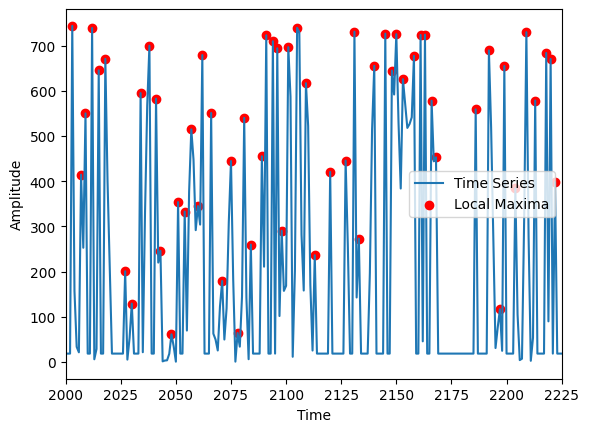

In [35]:
time = design_matrix['Bin']
# Plot the time series and local maxima
plt.plot(time, change_score, label='Time Series')
plt.scatter(time[local_maxima[0]], change_score[local_maxima[0]], color='red', label='Local Maxima')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim([2000, 2225])
plt.show()

In [ ]:
# Prepare grid
hs = [0.1, 0.2, 0.3]
sigmas = [0.3, 0.5, 0.6]

results_data = {}
smoothed_data = {}
results_control ={}
summary_results = {}

# Shuffle the data
shuffled_data = use_data.copy()
shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)  # Shuffle columns as well
    
for i, h in enumerate(hs):
    results_data[k][h] = {}
    smoothed_data[k][h] = {}
    results_control[k][h] = {}
    summary_results[k][h] = {}
    
    for isig, sigma in enumerate(sigmas):
    
        """ Data """
        change_score = stats(use_data, h, sigma, shuffle_iters)
        
        """ Control """
        shuffled_changepoints, smoothed_signal_shuffle = changepoint_detection_feature(shuffled_data, feature, k, h1, h2, sigma)
        
        """ Save results """
        results_data[k][h1][h2][sigma] = data_changepoints 
        smoothed_data[k][h1][h2][sigma] = smoothed_signal
        results_control[k][h1][h2][sigma] = shuffled_changepoints 
        summary_results[k][h1][h2][sigma] = [len(data_changepoints), len(shuffled_changepoints)]

In [ ]:

# Prepare grid
ks = [2, 3, 4]
hs = [0.1, 0.2, 0.3]
sigmas = [0.3, 0.5, 0.6]

results_data = {}
smoothed_data = {}
results_control ={}
summary_results = {}

# Shuffle the data
shuffled_data = use_data.copy()
shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)  # Shuffle columns as well

for ik, k in enumerate(ks):
    results_data[k] = {}
    smoothed_data[k] = {}
    results_control[k] = {}
    summary_results[k] = {}
    
    for ih, h1 in enumerate(hs1):
        results_data[k][h1] = {}
        smoothed_data[k][h1] = {}
        results_control[k][h1] = {}
        summary_results[k][h1] = {}

        for ih, h2 in enumerate(hs2):
            results_data[k][h1][h2] = {}
            smoothed_data[k][h1][h2] = {}
            results_control[k][h1][h2] = {}
            summary_results[k][h1][h2] = {}
        
            for isig, sigma in enumerate(sigmas):
            
                """ Data """
                data_changepoints, smoothed_signal = changepoint_detection_feature(use_data, feature, k, h1, h2, sigma)
                
                """ Control """
                shuffled_changepoints, smoothed_signal_shuffle = changepoint_detection_feature(shuffled_data, feature, k, h1, h2, sigma)
                
                """ Save results """
                results_data[k][h1][h2][sigma] = data_changepoints 
                smoothed_data[k][h1][h2][sigma] = smoothed_signal
                results_control[k][h1][h2][sigma] = shuffled_changepoints 
                summary_results[k][h1][h2][sigma] = [len(data_changepoints), len(shuffled_changepoints)]
                
# Optimize over grid           
expected_lag = 10
threshold = len(smoothed_signal)/(10*expected_lag)  # Allow for shuffled data to detect changepoints around once every 100 sec

max_changepoints = []
keys = []
for ik, k in enumerate(ks):
    
    for ih2, h1 in enumerate(hs1):
        
        for ih2, h2 in enumerate(hs2):
            
            for isig, sigma in enumerate(sigmas):
                #if summary_results[k][h1][h2][sigma][1] == 0:
                if (summary_results[k][h1][h2][sigma][1] < summary_results[k][h1][h2][sigma][0]) & (summary_results[k][h1][h2][sigma][1] <= threshold):

                    if len(max_changepoints) == 0:
                        max_changepoints = [summary_results[k][h1][h2][sigma][0]]
                        keys = [k, h1, h2, sigma]
                    else:
                        max_changepoints = np.vstack((max_changepoints, summary_results[k][h1][h2][sigma][0]))
                        keys = np.vstack((keys, [k, h1, h2, sigma]))
                        
if len(max_changepoints) > 0:
    
    # Choose parameters
    flat_changepoints = max_changepoints.ravel()
    use_keys = keys[flat_changepoints==np.max(flat_changepoints)]

    # Calculate changepoints based on optimal parameters
    k = int(use_keys[0][0])
    h1 = float(use_keys[0][1])
    h2 = float(use_keys[0][2])
    sigma = float(use_keys[0][3])

    data_changepoints, smoothed_signal = changepoint_detection_feature(use_data, feature, k, h1, h2, sigma)
    shuffled_changepoints, smoothed_shuff = changepoint_detection_feature(shuffled_data, feature, k, h1, h2, sigma)


In [ ]:
h = 0.8
sigma = 0.7
data_changepoints = changepoints(use_data, h, sigma)
shuffle_changepoints = shuffled(use_data, shuffle_iters, h, sigma)

timesteps = np.shape(use_data)[0]
change_score = np.zeros((timesteps))

# 1-sample t-test to compare data changepoints to shuffled distribution
for t in range(timesteps):
    # Perform one-sample t-test
    t_statistic, p_value = ttest_1samp(shuffle_changepoints[:, t], data_changepoints[t])
    change_score[t] = -np.log(p_value)


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


(0.0, 100.0)

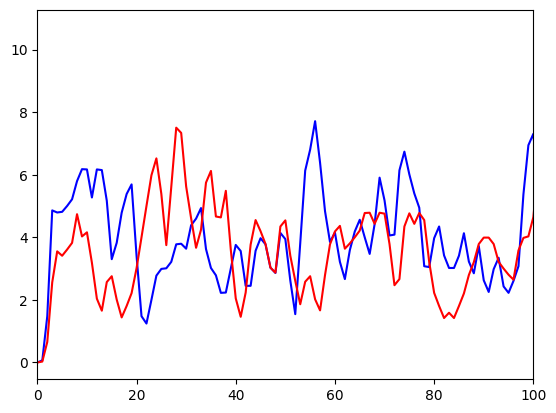

In [ ]:
plt.plot(data_changepoints, color='blue')
plt.plot(shuffle_changepoints[1, :], color='red')
plt.xlim([0, 100])

In [ ]:
def stats(use_data, shuffle_iters, h, sigma):
    
    data_changepoints = changepoints(use_data, h, sigma)
    shuffle_changepoints = shuffled(use_data, shuffle_iters, h, sigma)
    
    # 1-sample t-test to compare data changepoints to shuffled distribution


array([[4.09672364e-04, 6.78592373e-02, 1.52454352e+00, ...,
        1.10435938e+00, 4.85628511e-02, 2.92623117e-04],
       [2.92623117e-04, 4.85628511e-02, 1.10447643e+00, ...,
        1.29052117e+00, 5.80647326e-02, 3.51147741e-04],
       [2.92623117e-04, 4.85043264e-02, 1.09485750e+00, ...,
        2.35593663e+00, 1.06393485e-01, 6.43770858e-04],
       ...,
       [2.92623117e-04, 4.84458018e-02, 1.08500447e+00, ...,
        1.71082236e+00, 7.73611189e-02, 4.68196988e-04],
       [4.09672364e-04, 6.76836634e-02, 1.49592083e+00, ...,
        1.48606780e+00, 6.76251388e-02, 4.09672364e-04],
       [3.51147741e-04, 5.79476834e-02, 1.27128331e+00, ...,
        1.29052117e+00, 5.80647326e-02, 3.51147741e-04]])

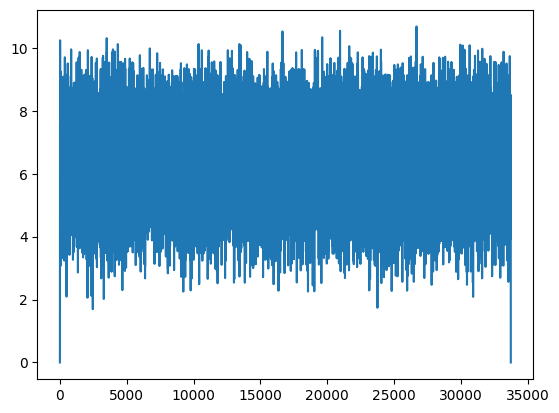

In [ ]:
plt.plot(changepoints_shuffled[100, :])

### Grid serach

In [227]:
def changepoint_detection(data, k, h1, h2, sigma):

    # Initialize
    derivative = data.copy()
    
    # Find first derivative and threshold
    #features = data.keys()[1:]
    features = data.keys()
    for i, feat in enumerate(features):
        derivative[feat] = derivative[feat] - derivative[feat].shift(k)    
    
    thresholded = derivative.copy()
    for i, feat in enumerate(features):
        # Thresold derivative
        thresholded.loc[(thresholded[feat] >= -h1) & (thresholded[feat] <= h1), feat] = 0
        thresholded.loc[thresholded[feat] >= h1, feat] = 1
        thresholded.loc[thresholded[feat] <= -h1, feat] = 1
    
    # Sum ove thresholded data
    summed_threshold = np.sum(thresholded, axis=1)
    # Apply Gaussian filter
    smoothed_signal = gaussian_filter1d(summed_threshold, sigma=sigma)
    
    # Detect local maxima
    local_maxima = argrelextrema(smoothed_signal, np.greater)
    
    # Keep local maxima is above a threshold
    crit = smoothed_signal[local_maxima[0]] > h2
    changepoints = local_maxima[0][crit]
    
    return changepoints, smoothed_signal

In [228]:
def changepoint_detection_feature(data, feature, k, h1, h2, sigma):

    # Initialize
    derivative = data.copy()
    
    # Find first derivative and threshold
    derivative[feature] = derivative[feature] - derivative[feature].shift(k)    
    
    thresholded = derivative.copy()
    # Thresold derivative
    thresholded.loc[(thresholded[feature] >= -h1) & (thresholded[feature] <= h1), feature] = 0
    thresholded.loc[thresholded[feature] >= h1, feature] = 1
    thresholded.loc[thresholded[feature] <= -h1, feature] = 1

    # Apply Gaussian filter
    smoothed_signal = gaussian_filter1d(thresholded[feature], sigma=sigma)
    
    # Detect local maxima
    local_maxima = argrelextrema(smoothed_signal, np.greater)
    
    # # Keep local maxima is above a threshold
    # crit = smoothed_signal[local_maxima[0]] > h2
    # changepoints = local_maxima[0][crit]
    
    changepoints = local_maxima[0]
    
    return changepoints, smoothed_signal

In [265]:
feature = 'pupil_diameter'

# Prepare grid
ks = [2, 3, 4, 5, 6]  # bin lag for derivative calculation
ks = [2, 3, 4]
#ks = [2]
hs1 = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 2, 2.5, 2.9, 3]  # thresold??
hs2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 1.1, 1.4, 1.5, 1.6, 1.7, 1.8, 1.85, 1.9, 1.95, 2, 2.5, 3]  # thresold??
sigmas = [0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.81, 0.82, 0.83, 0.85, 0.9, 0.95, 1, 1.5, 2, 3]  # for Gaussian filter

results_data = {}
smoothed_data = {}
results_control ={}
summary_results = {}

# Shuffle the data
shuffled_data = use_data.copy()
shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)  # Shuffle columns as well

for ik, k in enumerate(ks):
    results_data[k] = {}
    smoothed_data[k] = {}
    results_control[k] = {}
    summary_results[k] = {}
    
    for ih, h1 in enumerate(hs1):
        results_data[k][h1] = {}
        smoothed_data[k][h1] = {}
        results_control[k][h1] = {}
        summary_results[k][h1] = {}

        for ih, h2 in enumerate(hs2):
            results_data[k][h1][h2] = {}
            smoothed_data[k][h1][h2] = {}
            results_control[k][h1][h2] = {}
            summary_results[k][h1][h2] = {}
        
            for isig, sigma in enumerate(sigmas):
            
                """ Data """
                data_changepoints, smoothed_signal = changepoint_detection_feature(use_data, feature, k, h1, h2, sigma)
                
                """ Control """
                shuffled_changepoints, smoothed_signal_shuffle = changepoint_detection_feature(shuffled_data, feature, k, h1, h2, sigma)
                
                """ Save results """
                results_data[k][h1][h2][sigma] = data_changepoints 
                smoothed_data[k][h1][h2][sigma] = smoothed_signal
                results_control[k][h1][h2][sigma] = shuffled_changepoints 
                summary_results[k][h1][h2][sigma] = [len(data_changepoints), len(shuffled_changepoints)]
                
# Optimize over grid           
expected_lag = 10
threshold = len(smoothed_signal)/(10*expected_lag)  # Allow for shuffled data to detect changepoints around once every 100 sec

max_changepoints = []
keys = []
for ik, k in enumerate(ks):
    
    for ih2, h1 in enumerate(hs1):
        
        for ih2, h2 in enumerate(hs2):
            
            for isig, sigma in enumerate(sigmas):
                #if summary_results[k][h1][h2][sigma][1] == 0:
                if (summary_results[k][h1][h2][sigma][1] < summary_results[k][h1][h2][sigma][0]) & (summary_results[k][h1][h2][sigma][1] <= threshold):

                    if len(max_changepoints) == 0:
                        max_changepoints = [summary_results[k][h1][h2][sigma][0]]
                        keys = [k, h1, h2, sigma]
                    else:
                        max_changepoints = np.vstack((max_changepoints, summary_results[k][h1][h2][sigma][0]))
                        keys = np.vstack((keys, [k, h1, h2, sigma]))
                        
if len(max_changepoints) > 0:
    
    # Choose parameters
    flat_changepoints = max_changepoints.ravel()
    use_keys = keys[flat_changepoints==np.max(flat_changepoints)]

    # Calculate changepoints based on optimal parameters
    k = int(use_keys[0][0])
    h1 = float(use_keys[0][1])
    h2 = float(use_keys[0][2])
    sigma = float(use_keys[0][3])

    data_changepoints, smoothed_signal = changepoint_detection_feature(use_data, feature, k, h1, h2, sigma)
    shuffled_changepoints, smoothed_shuff = changepoint_detection_feature(shuffled_data, feature, k, h1, h2, sigma)


/tmp/ipykernel_7521/1808274003.py:22: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[0].set_ylim([np.min(smoothed_signal[init:end]), np.max(smoothed_signal[init:end])])


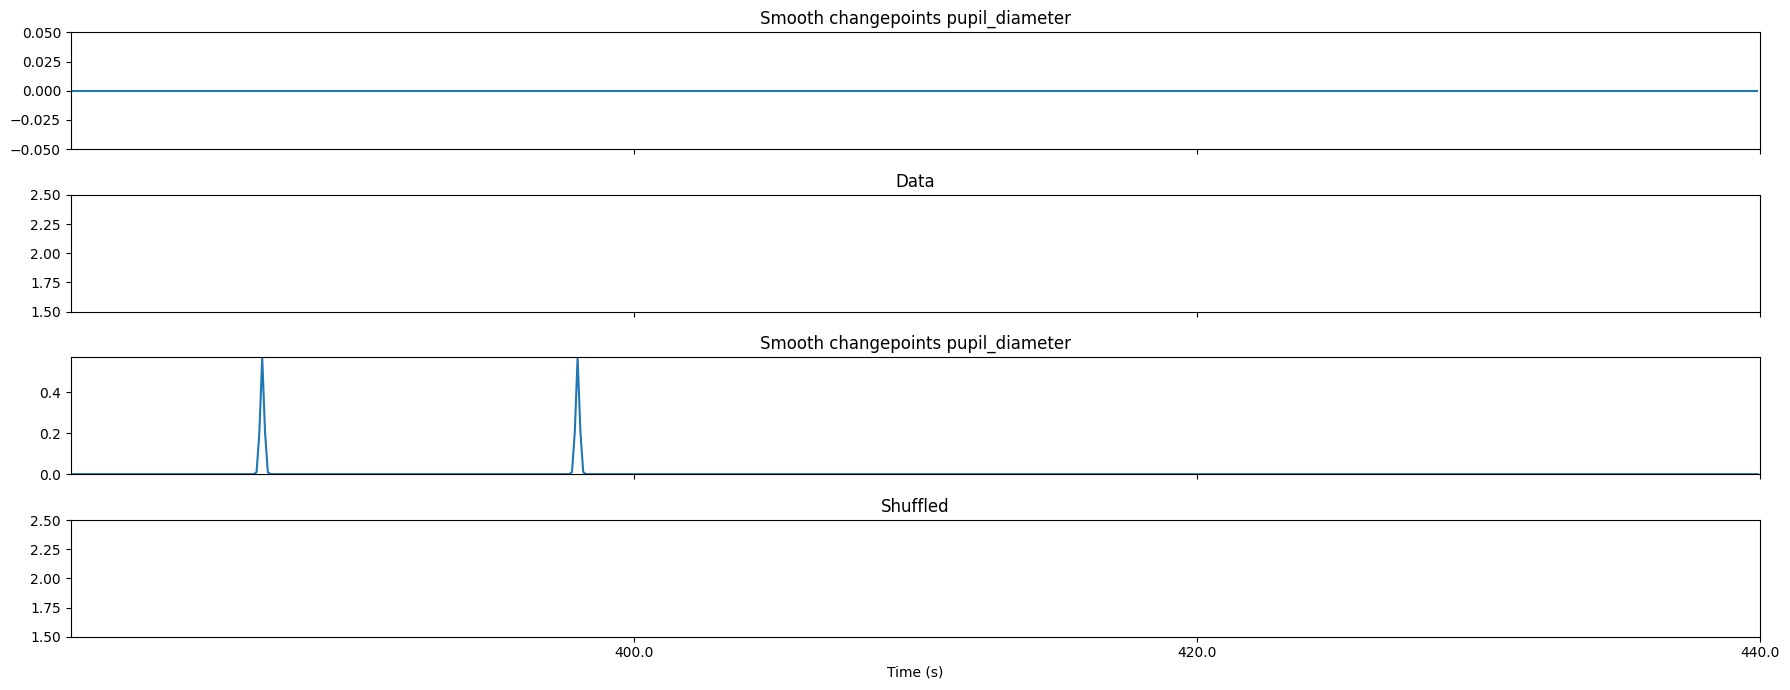

In [266]:

fig, ax = plt.subplots(nrows=4 , ncols=1, sharex=True, sharey=False, figsize=[18, 7])

interval = 600
init = 4000
end = init + interval

image_data = use_data * np.nan
image_data[feature] = use_data[feature]

image_data_shuff = shuffled_data * np.nan
image_data_shuff[feature] = shuffled_data[feature]

matrix = np.array(image_data[np.array(features)]).transpose()
shuf_matrix = np.array(image_data_shuff[np.array(features)]).transpose()
vlines_data = data_changepoints - init
vlines_shuf = shuffled_changepoints - init

# Plot the data matrix
ax[0].plot(smoothed_signal[init:end])
ax[0].hlines([h2], 0, interval, color='black', linewidth=1, linestyles='--')
ax[0].set_title(str('Smooth changepoints ' + feature))
ax[0].set_ylim([np.min(smoothed_signal[init:end]), np.max(smoothed_signal[init:end])])

# Plot the data matrix
im1 = ax[1].imshow(matrix[:, init:end], aspect='auto')
ax[1].vlines(vlines_data, -0.5+f, .5+f, color='white', linewidth=1, linestyles='--')
ax[1].set_title('Data')
ax[1].set_ylim([-0.5+f, 0.5+f])

# Plot the data matrix
ax[2].plot(smoothed_shuff[init:end])
ax[2].hlines([h2], 0, interval, color='black', linewidth=1, linestyles='--')
ax[2].set_title(str('Smooth changepoints '+ feature))
ax[2].set_ylim([np.min(smoothed_shuff[init:end]), np.max(smoothed_shuff[init:end])])


# Plot the control matrix
im2 = ax[3].imshow(shuf_matrix[:, init:end], aspect='auto')
ax[3].vlines(vlines_shuf, -0.5+f, .5+f, color='white', linewidth=1, linestyles='--')
ax[3].set_xlabel('Time (s)')
ax[3].set_xlim([0, interval])
ax[3].set_title('Shuffled')
ax[3].set_ylim([-0.5+f, 0.5+f])
# labels = [init/10 , init/10+20, init/10+40, init/10+60, init/10+80]
# ax[2].set_xticks([200, 400, 600, 800, 1000], labels)
labels = [init/10 , init/10+20, init/10+40]
ax[3].set_xticks([200, 400, 600], labels)
#ax[2].set_xticks([100, 200, 300], labels)

plt.tight_layout()
plt.show()

## Changepoints per feature

24.5
105.0


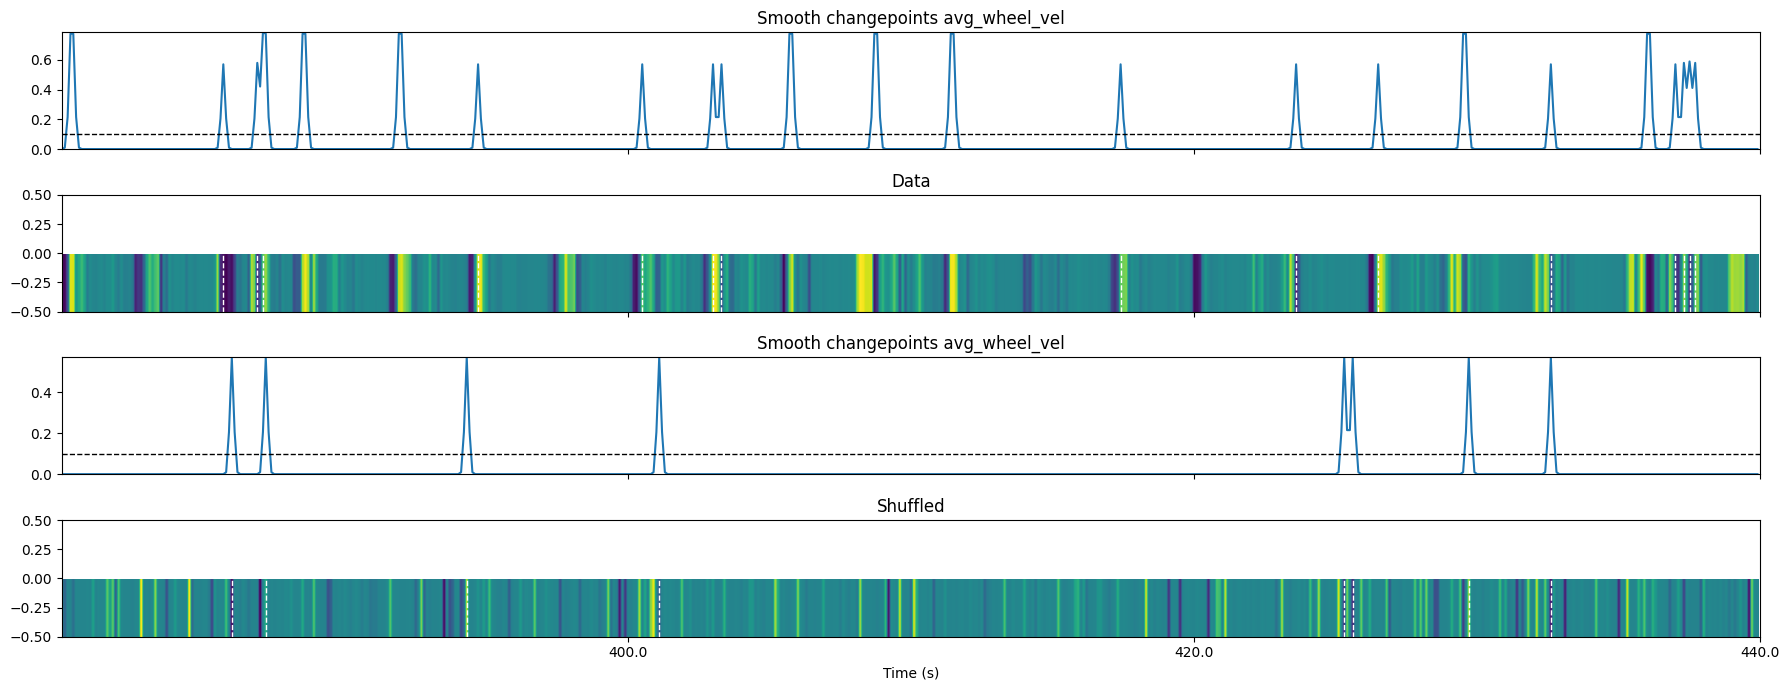

nan
nan


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_7521/3434946793.py:132: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[0].set_ylim([np.min(smoothed_signal[init:end]), np.max(smoothed_signal[init:end])])
/tmp/ipykernel_7521/3434946793.py:144: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[2].set_ylim([np.min(smoothed_shuff[init:end]), np.max(smoothed_shuff[init:end])])


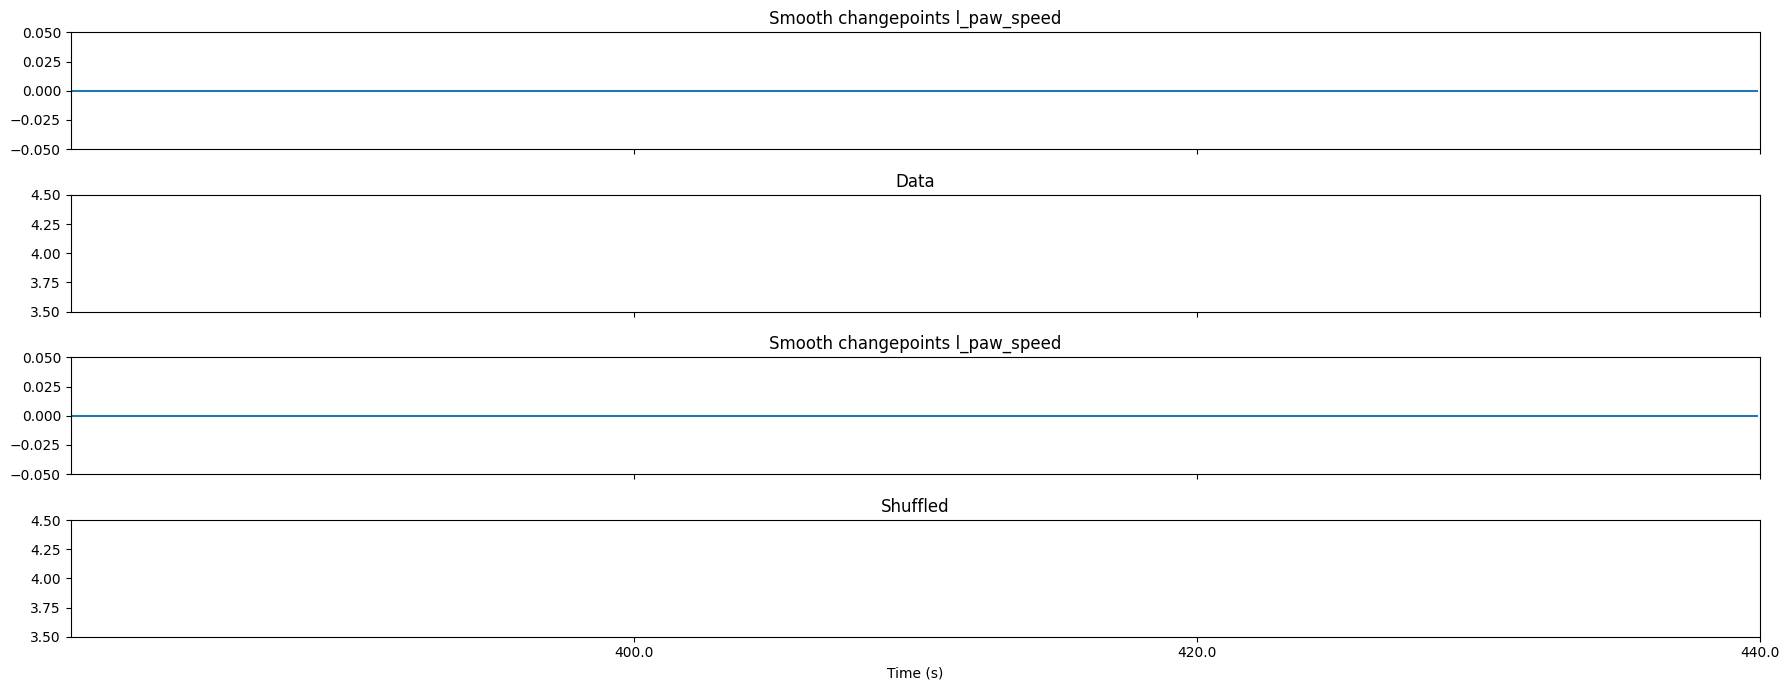

1470.0
7961.0


/tmp/ipykernel_7521/3434946793.py:132: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[0].set_ylim([np.min(smoothed_signal[init:end]), np.max(smoothed_signal[init:end])])
/tmp/ipykernel_7521/3434946793.py:144: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[2].set_ylim([np.min(smoothed_shuff[init:end]), np.max(smoothed_shuff[init:end])])


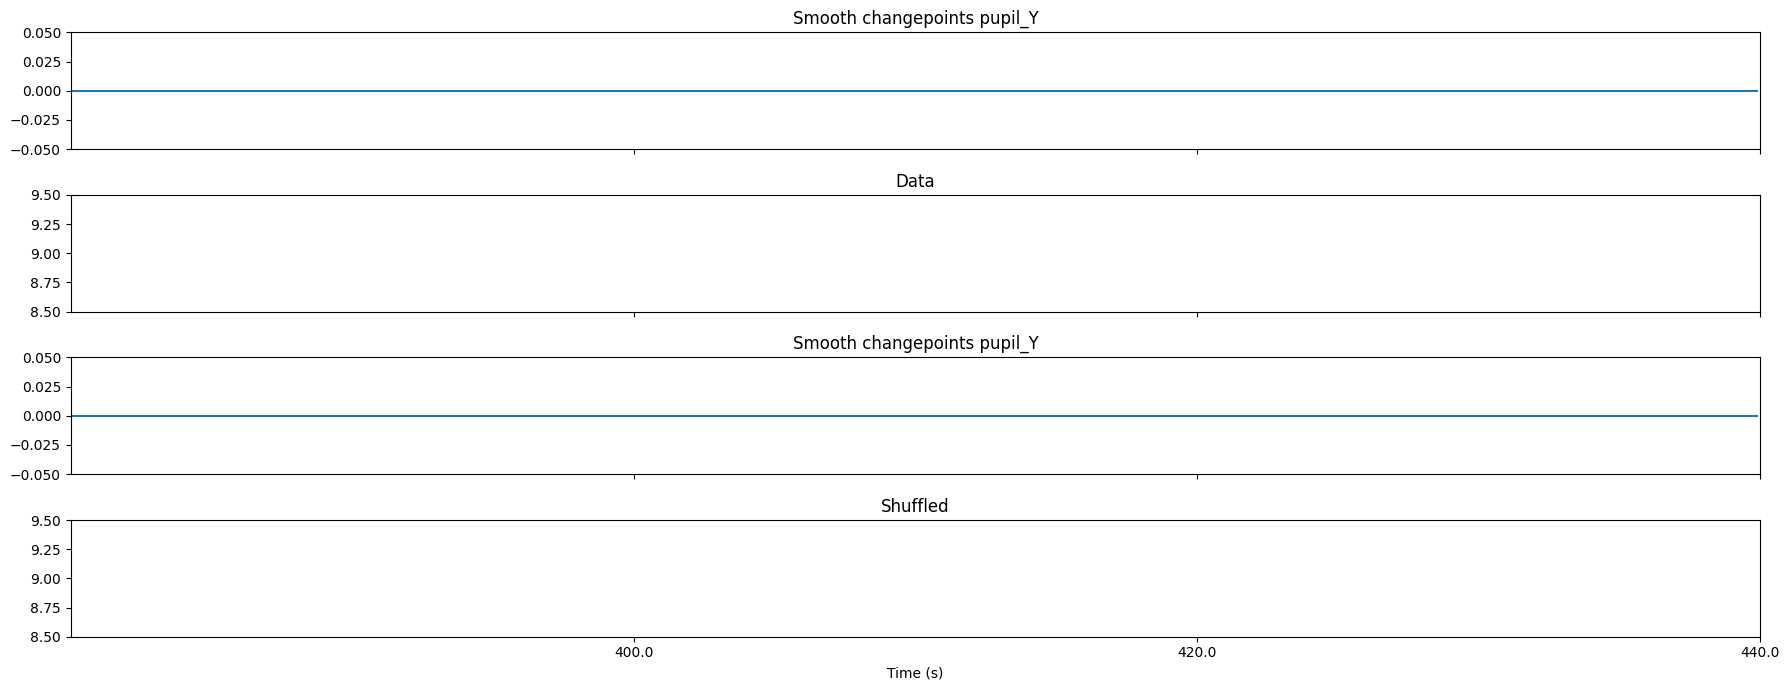

In [292]:
features = var_names 

for f, feature in enumerate(features):
    
    # Prepare grid
    ks = [2, 3, 4, 5, 6]  # bin lag for derivative calculation
    ks = [2, 3, 4]
    #ks = [2]
    hs1 = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 2, 2.5, 2.9, 3]  # thresold??
    hs2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 1.1, 1.4, 1.5, 1.6, 1.7, 1.8, 1.85, 1.9, 1.95, 2, 2.5, 3]  # thresold??
    sigmas = [0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.81, 0.82, 0.83, 0.85, 0.9, 0.95, 1, 1.5, 2, 3]  # for Gaussian filter

    results_data = {}
    smoothed_data = {}
    results_control ={}
    summary_results = {}

    # Shuffle the data
    shuffled_data = use_data.copy()
    shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)  # Shuffle columns as well

    for ik, k in enumerate(ks):
        results_data[k] = {}
        smoothed_data[k] = {}
        results_control[k] = {}
        summary_results[k] = {}
        
        for ih, h1 in enumerate(hs1):
            results_data[k][h1] = {}
            smoothed_data[k][h1] = {}
            results_control[k][h1] = {}
            summary_results[k][h1] = {}

            for ih, h2 in enumerate(hs2):
                results_data[k][h1][h2] = {}
                smoothed_data[k][h1][h2] = {}
                results_control[k][h1][h2] = {}
                summary_results[k][h1][h2] = {}
            
                for isig, sigma in enumerate(sigmas):
                
                    """ Data """
                    data_changepoints, smoothed_signal = changepoint_detection_feature(use_data, feature, k, h1, h2, sigma)
                    
                    """ Control """
                    shuffled_changepoints, _ = changepoint_detection_feature(shuffled_data, feature, k, h1, h2, sigma)
                    
                    """ Save results """
                    results_data[k][h1][h2][sigma] = data_changepoints 
                    smoothed_data[k][h1][h2][sigma] = smoothed_signal
                    results_control[k][h1][h2][sigma] = shuffled_changepoints 
                    summary_results[k][h1][h2][sigma] = [len(data_changepoints), len(shuffled_changepoints)]
                    
    # Optimize over grid           
    expected_lag = 10
    threshold = len(smoothed_signal)/(10*expected_lag)  # Allow for shuffled data to detect changepoints around once every 100 sec

    max_changepoints = []
    keys = []
    for ik, k in enumerate(ks):
        
        for ih2, h1 in enumerate(hs1):
            
            for ih2, h2 in enumerate(hs2):
                
                for isig, sigma in enumerate(sigmas):
                    #if summary_results[k][h1][h2][sigma][1] == 0:
                    if (summary_results[k][h1][h2][sigma][1] < summary_results[k][h1][h2][sigma][0]) & (summary_results[k][h1][h2][sigma][1] <= threshold):

                        if len(max_changepoints) == 0:
                            max_changepoints = [summary_results[k][h1][h2][sigma][0]]
                            keys = [k, h1, h2, sigma]
                        else:
                            max_changepoints = np.vstack((max_changepoints, summary_results[k][h1][h2][sigma][0]))
                            keys = np.vstack((keys, [k, h1, h2, sigma]))
                            
    if len(max_changepoints) > 0:
        
        # Choose parameters
        flat_changepoints = max_changepoints.ravel()
        use_keys = keys[flat_changepoints==np.max(flat_changepoints)]

        # Calculate changepoints based on optimal parameters
        k = int(use_keys[0][0])
        h1 = float(use_keys[0][1])
        h2 = float(use_keys[0][2])
        sigma = float(use_keys[0][3])

        data_changepoints, smoothed_signal = changepoint_detection_feature(use_data, feature, k, h1, h2, sigma)
        shuffled_changepoints, smoothed_shuff = changepoint_detection_feature(shuffled_data, feature, k, h1, h2, sigma)

        # # Plot 
        # plt.hist(np.diff(data_changepoints), bins=5000)
        # plt.xlim([0, 50])
        # plt.xlabel('Changepoint interval duration (s)')
        # plt.xticks([10, 20, 30, 40, 50], [1, 2, 3, 4, 5])
        # plt.title('Data')
        # plt.show()

        # plt.hist(np.diff(shuffled_changepoints), bins=5000)
        # plt.xlim([0, 50])
        # plt.xlabel('Changepoint interval duration (s)')
        # plt.xticks([10, 20, 30, 40, 50], [1, 2, 3, 4, 5])
        # plt.title('Shuffled')
        # plt.show()

        print(np.median(np.diff(data_changepoints)))
        print(np.median(np.diff(shuffled_changepoints)))


        fig, ax = plt.subplots(nrows=4 , ncols=1, sharex=True, sharey=False, figsize=[18, 7])

        interval = 600
        init = 4000
        end = init + interval

        image_data = use_data * np.nan
        image_data[feature] = use_data[feature]

        image_data_shuff = shuffled_data * np.nan
        image_data_shuff[feature] = shuffled_data[feature]

        matrix = np.array(image_data[np.array(features)]).transpose()
        shuf_matrix = np.array(image_data_shuff[np.array(features)]).transpose()
        vlines_data = data_changepoints - init
        vlines_shuf = shuffled_changepoints - init

        # Plot the data matrix
        ax[0].plot(smoothed_signal[init:end])
        ax[0].hlines([h2], 0, interval, color='black', linewidth=1, linestyles='--')
        ax[0].set_title(str('Smooth changepoints ' + feature))
        ax[0].set_ylim([np.min(smoothed_signal[init:end]), np.max(smoothed_signal[init:end])])

        # Plot the data matrix
        im1 = ax[1].imshow(matrix[:, init:end], aspect='auto')
        ax[1].vlines(vlines_data, -0.5+f, .5+f, color='white', linewidth=1, linestyles='--')
        ax[1].set_title('Data')
        ax[1].set_ylim([-0.5+f, 0.5+f])

        # Plot the data matrix
        ax[2].plot(smoothed_shuff[init:end])
        ax[2].hlines([h2], 0, interval, color='black', linewidth=1, linestyles='--')
        ax[2].set_title(str('Smooth changepoints '+ feature))
        ax[2].set_ylim([np.min(smoothed_shuff[init:end]), np.max(smoothed_shuff[init:end])])


        # Plot the control matrix
        im2 = ax[3].imshow(shuf_matrix[:, init:end], aspect='auto')
        ax[3].vlines(vlines_shuf, -0.5+f, .5+f, color='white', linewidth=1, linestyles='--')
        ax[3].set_xlabel('Time (s)')
        ax[3].set_xlim([0, interval])
        ax[3].set_title('Shuffled')
        ax[3].set_ylim([-0.5+f, 0.5+f])
        # labels = [init/10 , init/10+20, init/10+40, init/10+60, init/10+80]
        # ax[2].set_xticks([200, 400, 600, 800, 1000], labels)
        labels = [init/10 , init/10+20, init/10+40]
        ax[3].set_xticks([200, 400, 600], labels)
        #ax[2].set_xticks([100, 200, 300], labels)

        plt.tight_layout()
        plt.show()


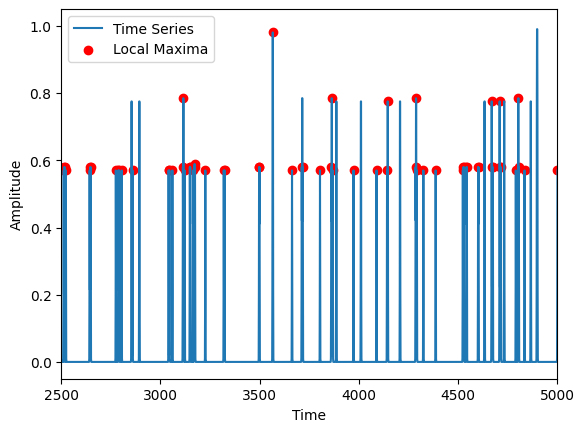

In [119]:
local_maxima = argrelextrema(smoothed_signal, np.greater)

time = design_matrix['Bin']
# Plot the time series and local maxima
plt.plot(time, smoothed_signal, label='Time Series')
plt.scatter(time[local_maxima[0]], smoothed_signal[local_maxima[0]], color='red', label='Local Maxima')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim([2500, 5000])
plt.show()

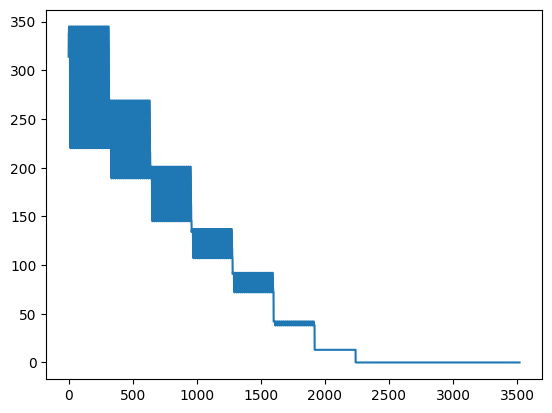

In [120]:
plt.plot(max_changepoints)

## Global changepoints

In [35]:
ks = [2, 3, 4, 5, 6]  # bin lag for derivative calculation
ks = [2, 3, 4]
ks = [2]
hs1 = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 2, 2.5, 2.9, 3]  # thresold??
hs2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 1.1, 1.4, 1.5, 1.6, 1.7, 1.8, 1.85, 1.9, 1.95, 2, 2.5, 3]  # thresold??
sigmas = [0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.81, 0.82, 0.83, 0.85, 0.9, 0.95, 1, 1.5, 2, 3]  # for Gaussian filter

results_data = {}
smoothed_data = {}
results_control ={}
summary_results = {}

features = use_data.keys()   # [1:]

# Shuffle the data
shuffled_data = use_data.copy()
shuffled_data = shuffled_data.sample(frac=1).reset_index(drop=True)  # Shuffle columns as well
#shuffled_data[np.array(features)] = shuffled_data[np.array(features)].sample(frac=1, axis=0).sample(frac=1, axis=1)  # Shuffle both rows and columns

for ik, k in enumerate(ks):
    results_data[k] = {}
    smoothed_data[k] = {}
    results_control[k] = {}
    summary_results[k] = {}
    
    for ih, h1 in enumerate(hs1):
        results_data[k][h1] = {}
        smoothed_data[k][h1] = {}
        results_control[k][h1] = {}
        summary_results[k][h1] = {}

        for ih, h2 in enumerate(hs2):
            results_data[k][h1][h2] = {}
            smoothed_data[k][h1][h2] = {}
            results_control[k][h1][h2] = {}
            summary_results[k][h1][h2] = {}
        
            for isig, sigma in enumerate(sigmas):
            
                """ Data """
                data_changepoints, smoothed_signal = changepoint_detection(use_data, k, h1, h2, sigma)
                
                """ Control """
                shuffled_changepoints, _ = changepoint_detection(shuffled_data, k, h1, h2, sigma)
                
                """ Save results """
                results_data[k][h1][h2][sigma] = data_changepoints 
                smoothed_data[k][h1][h2][sigma] = smoothed_signal
                results_control[k][h1][h2][sigma] = shuffled_changepoints 
                summary_results[k][h1][h2][sigma] = [len(data_changepoints), len(shuffled_changepoints)]


In [58]:
expected_lag = 10
threshold = len(smoothed_signal)/(10*expected_lag)  # Allow for shuffled data to detect changepoints around once every 100 sec

max_changepoints = []
keys = []
for ik, k in enumerate(ks):
    
    for ih2, h1 in enumerate(hs1):
        
        for ih2, h2 in enumerate(hs2):
    
            for isig, sigma in enumerate(sigmas):
                #if summary_results[k][h1][h2][sigma][1] == 0:
                if summary_results[k][h1][h2][sigma][1] <= threshold:

                    if len(max_changepoints) == 0:
                        max_changepoints = [summary_results[k][h1][h2][sigma][0]]
                        keys = [k, h1, h2, sigma]
                    else:
                        max_changepoints = np.vstack((max_changepoints, summary_results[k][h1][h2][sigma][0]))
                        keys = np.vstack((keys, [k, h1, h2, sigma]))


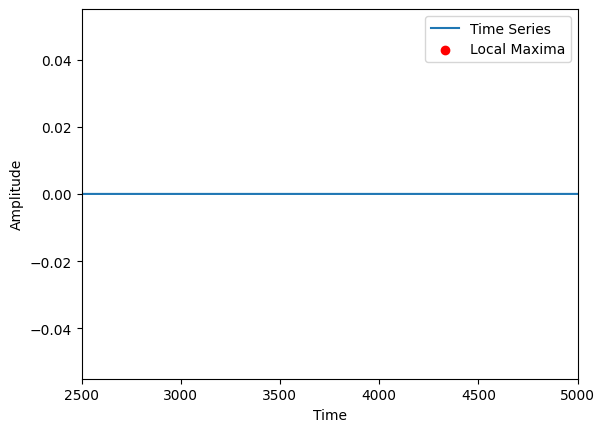

In [59]:
local_maxima = argrelextrema(smoothed_signal, np.greater)

time = design_matrix['Bin']
# Plot the time series and local maxima
plt.plot(time, smoothed_signal, label='Time Series')
plt.scatter(time[local_maxima[0]], smoothed_signal[local_maxima[0]], color='red', label='Local Maxima')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim([2500, 5000])
plt.show()

In [60]:
flat_changepoints = max_changepoints.ravel()
use_keys = keys[flat_changepoints==np.max(flat_changepoints)]
use_keys

array([[2.  , 0.45, 0.6 , 0.9 ],
       [2.  , 0.45, 0.6 , 0.95],
       [2.  , 0.45, 0.6 , 1.  ]])

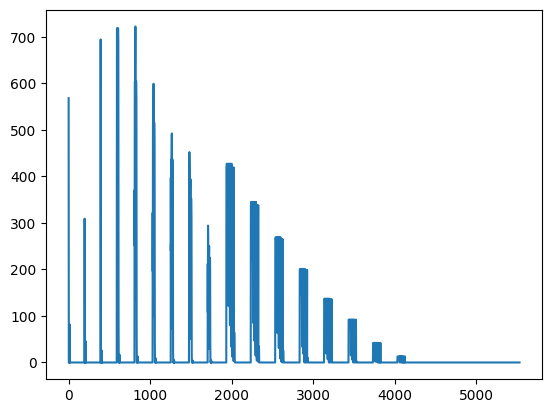

In [61]:
plt.plot(max_changepoints)

### Optimal changepoints

In [62]:
sigma = 0.8
k = 2
h1 = 0.5
h2 = 1

k = int(use_keys[0][0])
h1 = float(use_keys[0][1])
h2 = float(use_keys[0][2])
sigma = float(use_keys[0][3])

data_changepoints, smoothed_signal = changepoint_detection(use_data, k, h1, h2, sigma)
shuffled_changepoints, smoothed_shuff = changepoint_detection(shuffled_data, k, h1, h2, sigma)

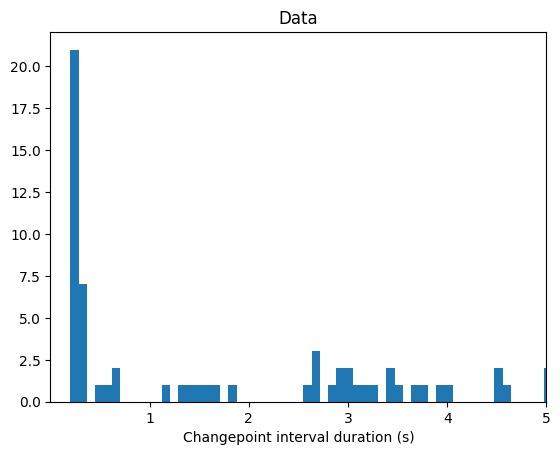

62.0
71.0


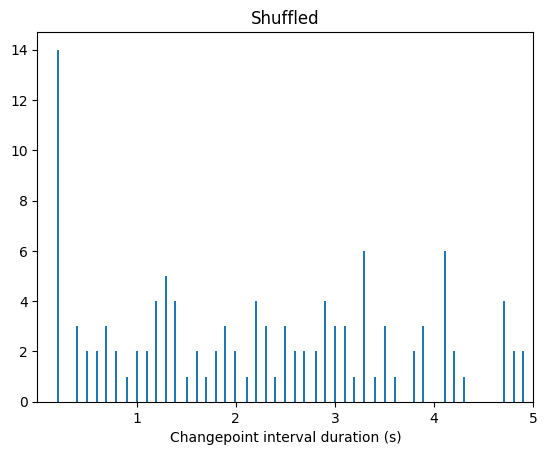

In [41]:
plt.hist(np.diff(data_changepoints), bins=5000)
plt.xlim([0, 50])
plt.xlabel('Changepoint interval duration (s)')
plt.xticks([10, 20, 30, 40, 50], [1, 2, 3, 4, 5])
plt.title('Data')
plt.show()

plt.hist(np.diff(shuffled_changepoints), bins=5000)
plt.xlim([0, 50])
plt.xlabel('Changepoint interval duration (s)')
plt.xticks([10, 20, 30, 40, 50], [1, 2, 3, 4, 5])
plt.title('Shuffled')

print(np.median(np.diff(data_changepoints)))
print(np.median(np.diff(shuffled_changepoints)))


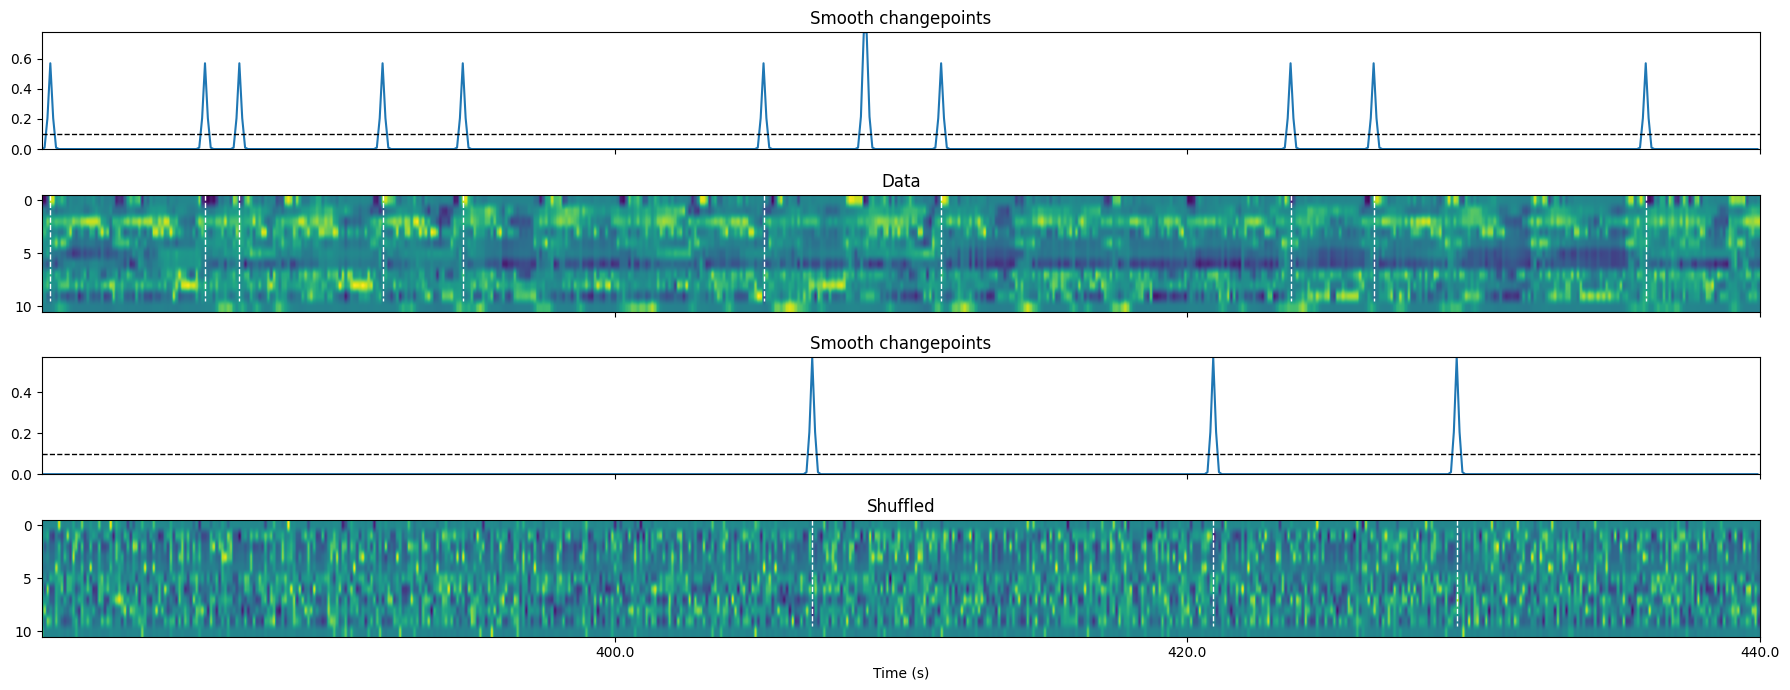

In [42]:
fig, ax = plt.subplots(nrows=4 , ncols=1, sharex=True, sharey=False, figsize=[18, 7])

interval = 600
init = 4000
end = init + interval

matrix = np.array(use_data[np.array(features)]).transpose()
shuf_matrix = np.array(shuffled_data[np.array(features)]).transpose()
vlines_data = data_changepoints - init
vlines_shuf = shuffled_changepoints - init

# Plot the data matrix
ax[0].plot(smoothed_signal[init:end])
ax[0].hlines([h2], 0, interval, color='black', linewidth=1, linestyles='--')
ax[0].set_title('Smooth changepoints')
ax[0].set_ylim([np.min(smoothed_signal[init:end]), np.max(smoothed_signal[init:end])])

# Plot the data matrix
im1 = ax[1].imshow(matrix[:, init:end], aspect='auto')
ax[1].vlines(vlines_data, -0.5, 9.5, color='white', linewidth=1, linestyles='--')
ax[1].set_title('Data')

# Plot the data matrix
ax[2].plot(smoothed_shuff[init:end])
ax[2].hlines([h2], 0, interval, color='black', linewidth=1, linestyles='--')
ax[2].set_title('Smooth changepoints')
ax[2].set_ylim([np.min(smoothed_shuff[init:end]), np.max(smoothed_shuff[init:end])])


# Plot the control matrix
im2 = ax[3].imshow(shuf_matrix[:, init:end], aspect='auto')
ax[3].vlines(vlines_shuf, -0.5, 9.5, color='white', linewidth=1, linestyles='--')
ax[3].set_xlabel('Time (s)')
ax[3].set_xlim([0, interval])
ax[3].set_title('Shuffled')
# labels = [init/10 , init/10+20, init/10+40, init/10+60, init/10+80]
# ax[2].set_xticks([200, 400, 600, 800, 1000], labels)
labels = [init/10 , init/10+20, init/10+40]
ax[3].set_xticks([200, 400, 600], labels)
#ax[2].set_xticks([100, 200, 300], labels)

plt.tight_layout()

## Add colorbar
#cbar1 = fig.colorbar(im1, ax=ax[1])
#cbar2 = fig.colorbar(im2, ax=ax[2])


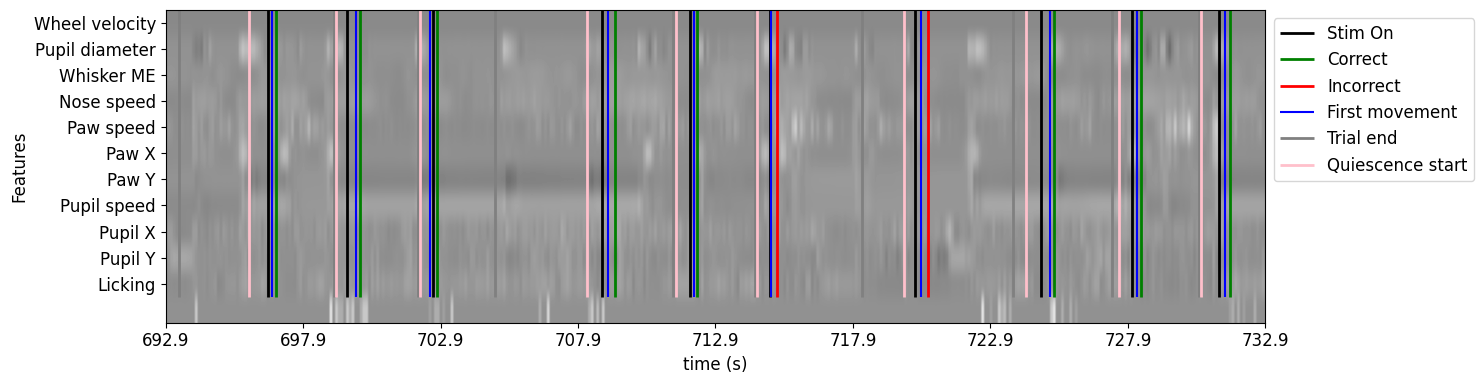

In [31]:
init = 6000
end = init + 400
plt.rc('font', size=12)

fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 4))

cmap = plt.cm.gray
use_data = scaler.fit_transform(X)
im1 = axs.imshow(use_data.transpose(), aspect='auto', cmap=cmap)  # [:, init:end]
bin_init = design_matrix['Bin'][0]


axs.vlines(np.array(session_trials['goCueTrigger_times'] * 10 - bin_init),-0.5, 10.5, label='Stim On', color='Black', linewidth=2)
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10 - bin_init), -0.5, 10.5, label='Correct', color='Green', linewidth=2)
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 10 - bin_init), -0.5, 10.5, label='Incorrect', color='Red', linewidth=2)
axs.vlines(np.array(session_trials['firstMovement_times'] * 10 - bin_init), -0.5, 10.5, label='First movement', color='Blue')
axs.vlines(np.array(session_trials['intervals_0'] * 10 - bin_init), -0.5, 10.5, label='Trial end', color='Grey', linewidth=2)
axs.vlines(np.array((session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']) * 10 - bin_init), -0.5, 10.5, label='Quiescence start', color='Pink', linewidth=2)
#axs.set_ylim(0, 1)

axs.set_ylabel("Features")
axs.set_xlabel("time (s)")
axs.set_xlim(init, end)
axs.set_xticks(np.arange(init, end+50, 50),np.arange((init+bin_init)/10, (end+bin_init)/10+5, 5))
feature_names = ['Wheel velocity', 'Pupil diameter', 'Whisker ME', 'Nose speed', 'Paw speed', 'Paw X', 'Paw Y', 'Pupil speed', 'Pupil X', 'Pupil Y', 'Licking']
axs.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], feature_names)
axs.legend(loc='upper left', bbox_to_anchor=(1, 1))
cbar1 = fig.colorbar(im1, ax=ax)

plt.tight_layout()
plt.show()

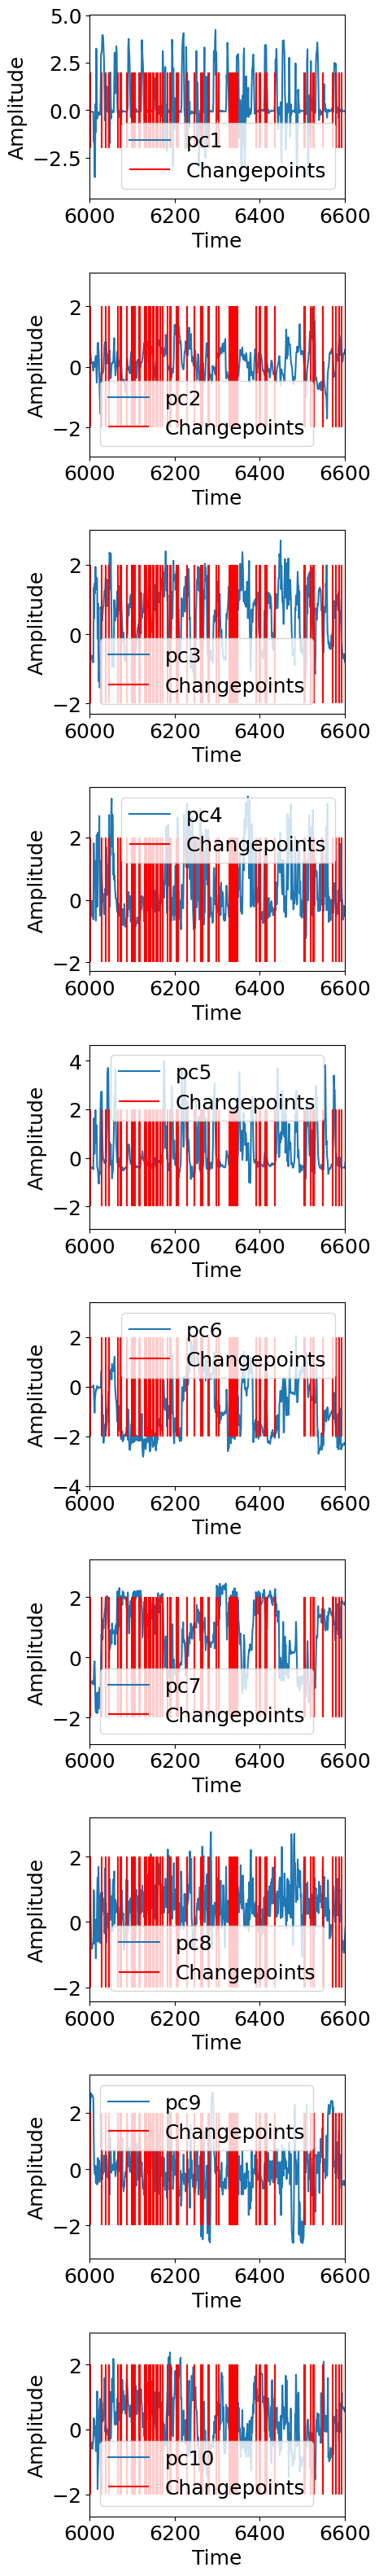

In [296]:
derivative = augmented_data.copy()
pcs = augmented_data.keys()[1:]

min = 6000
max = min + 600

fig, ax = plt.subplots(nrows=len(pcs) , ncols=1, sharex=False, sharey=False, figsize=[5, 32])

for i, pc in enumerate(pcs):
    
    #time = augmented_data['Bin']
    time = np.arange(0, len(augmented_data['Bin']), 1)
    # Plot the time series and local maxima
    ax[i].plot(time, augmented_data[pc], label=pc)
    ax[i].vlines(data_changepoints, -2, 2, color='red', label='Changepoints')
    ax[i].legend()
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Amplitude')
    ax[i].set_xlim([min, max])
    
plt.tight_layout()
